## Compare Step-Index computations

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from scipy.io import savemat

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from mmfsim.phase import LinearPhase
from mmfsim.grid import Grid
from mmfsim.fiber import StepIndexFiber
from mmfsim.beams import GaussianBeam
from mmfsim.speckle import StepIndexSpeckle
from mmfsim.coupling import StepIndexFiberDegenCoupler
from mmfsim.transforms import fresnel_transform, fourier_transform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Input variables

In [3]:
fiber_radius = 25e-6
fiber_length = 1e0
power_n = 8
grid_length = 2 ** power_n
grid_size = 2.2 * fiber_radius
pixel_size = grid_size / grid_length

fiber_kwargs = dict(radius=fiber_radius, wavelength=1064e-9, n1=1.467, n2=1.455)
grid_kwargs = dict(pixel_size=pixel_size, pixel_numbers=(grid_length, grid_length))

### Define the fiber

In [4]:
grid = Grid(**grid_kwargs)
fiber = StepIndexFiber(**fiber_kwargs)
print(fiber)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:247: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)
c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:248: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))


StepIndexFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.467
  - Cladding index: 1.455
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.187
  - Number of guided LP modes: 103
  - Number of guided LP modes (counting degenerates): 197
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46691577  0.          0.          1.        ]
 [ 1.46678618  2.          1.          1.        ]
 [ 1.46661592  4.          2.          1.        ]
 [ 1.46655631  1.          0.          2.        ]
 [ 1.46640725  6.          3.          1.        ]
 [ 1.46628345  3.          1.          2.        ]
 [ 1.46616156  8.          4.          1.        ]
 [ 1.46596871  5.          2.          2.        ]
 [ 1.46591006  2.          0.          3.        ]
 [ 1.46587979 10.          5.          1.        ]]


In [5]:
fiber.compute_modes_fields(grid)

### Define an excitation beam with a linear phase

In [6]:
phase = LinearPhase(grid)
phase.compute(coeffs=[1e-4,1])

beam = GaussianBeam(grid)
beam.compute(amplitude=1, width=10e-6, centers=[30e-6,0])
beam.add_phase(phase.phase)

coupled_in = StepIndexFiberDegenCoupler(beam.field, grid, fiber, N_modes=fiber._N_modes_degen)

### Define a propagation matrix with no mode coupling

First I need to concatenate $\beta$ for non-centro-symmetric modes

Now let's create the propagation matrix with no mode energy exchange, this matrix is diagonal.
Then compute the new modes coefficients. Only their phases should have changed.

### Get the speckle at the fiber output

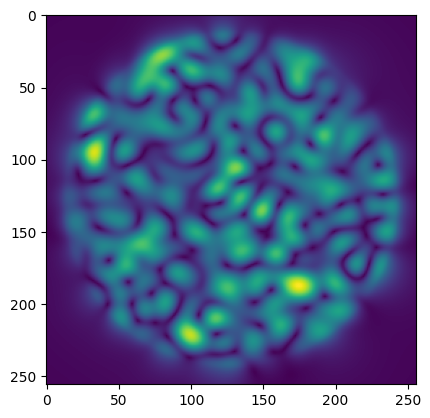

In [7]:
coupling_matrix = fiber.modes_coupling_matrix(complex=True, full=False, degen=True)
propagated_field = coupled_in.propagate()
plt.imshow(np.abs(propagated_field))

In [14]:
def plot_fields(field1: np.ndarray, field2: np.ndarray, intensity: bool = True, name: tuple[str] = ('', ''), figsize: tuple[float, float] = (15,4)) -> None:
    intensity_str = '(intensity)' if intensity else '(amplitude)'
    phase_str = '(phase)'
    
    fig, axs = plt.subplots(2, 3, figsize=figsize)
    axs[0,0].set_title(f"{name[0]} {intensity_str}")
    pl0 = axs[0,0].imshow(np.square(np.abs(field1)) if intensity else np.abs(field1), cmap='gray')
    plt.colorbar(pl0, ax=axs[0,0])
    
    axs[1,0].set_title(f"{name[0]} {phase_str}")
    pl1 = axs[1,0].imshow(np.angle(field1), cmap='twilight')
    plt.colorbar(pl1, ax=axs[1,0])

    axs[0,1].set_title(f"{name[1]} {intensity_str}")
    pl2 = axs[0,1].imshow(np.square(np.abs(field2)) if intensity else np.abs(field2), cmap='gray')
    plt.colorbar(pl2, ax=axs[0,1])
    
    axs[1,1].set_title(f"{name[1]} {phase_str}")
    pl3 = axs[1,1].imshow(np.angle(field2), cmap='twilight')
    plt.colorbar(pl3, ax=axs[1,1])
    
    
    diff_amp = np.abs(field2) - np.abs(field1)
    diff_phase = np.angle(np.exp(1j * (np.angle(field2) - np.angle(field1))))

    axs[0,2].set_title(f"Amplitude difference")
    pl4 = axs[0,2].imshow(diff_amp, cmap='bwr')
    plt.colorbar(pl4, ax=axs[0,2])
    
    axs[1,2].set_title(f"Phase difference")
    pl5 = axs[1,2].imshow(diff_phase, cmap='bwr')
    plt.colorbar(pl5, ax=axs[1,2])

### Fourier transform the output speckle after padding it

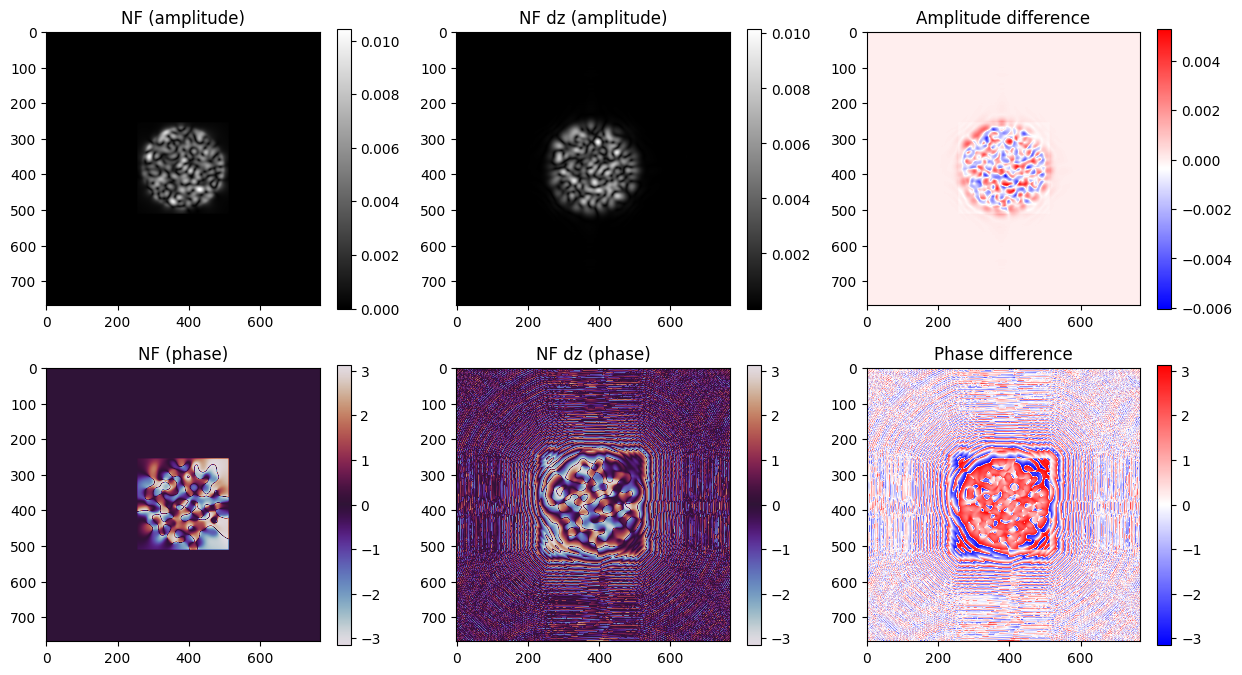

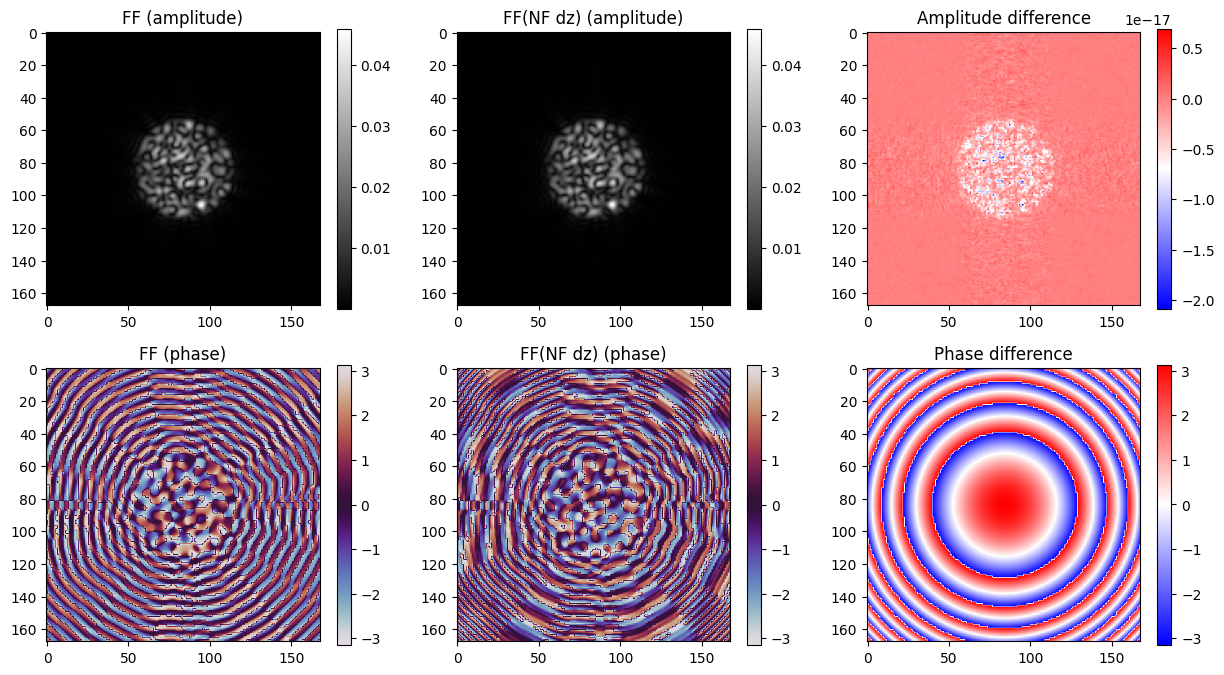

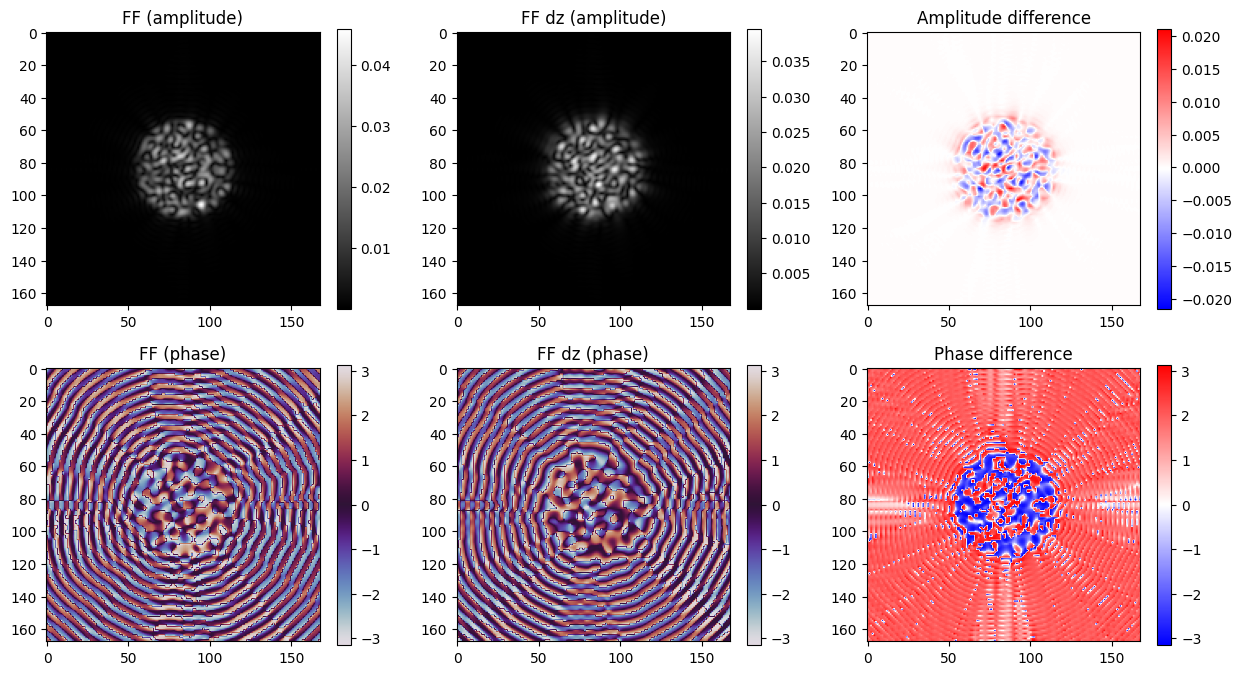

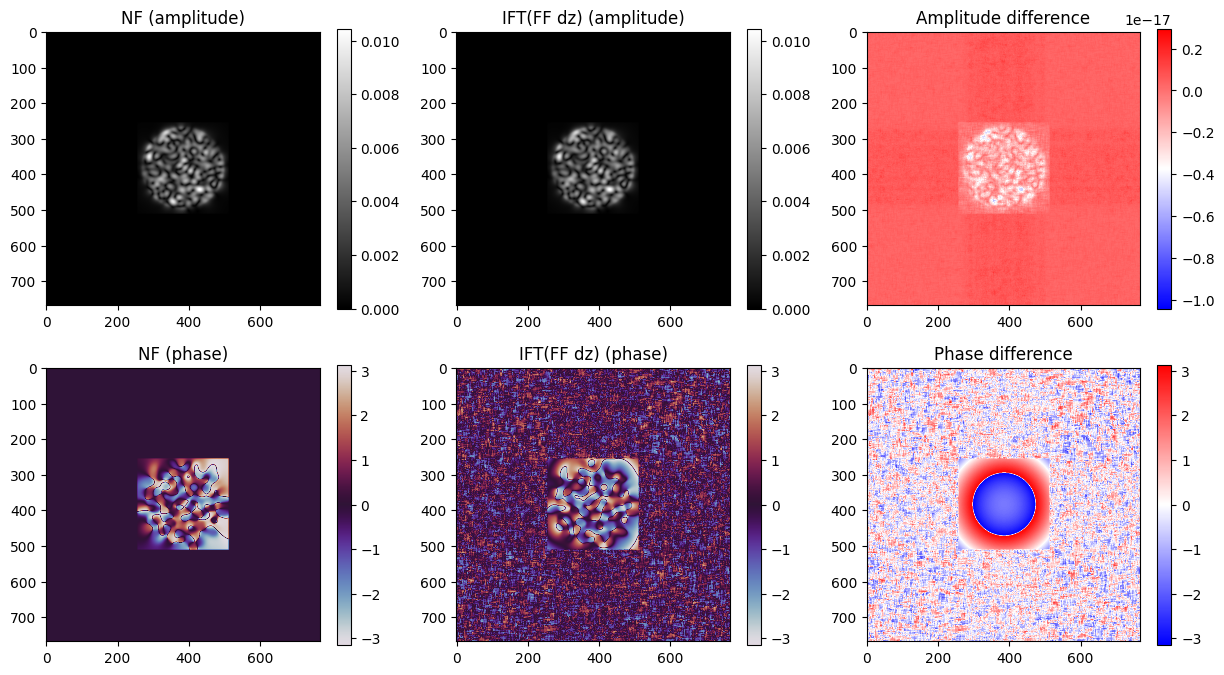

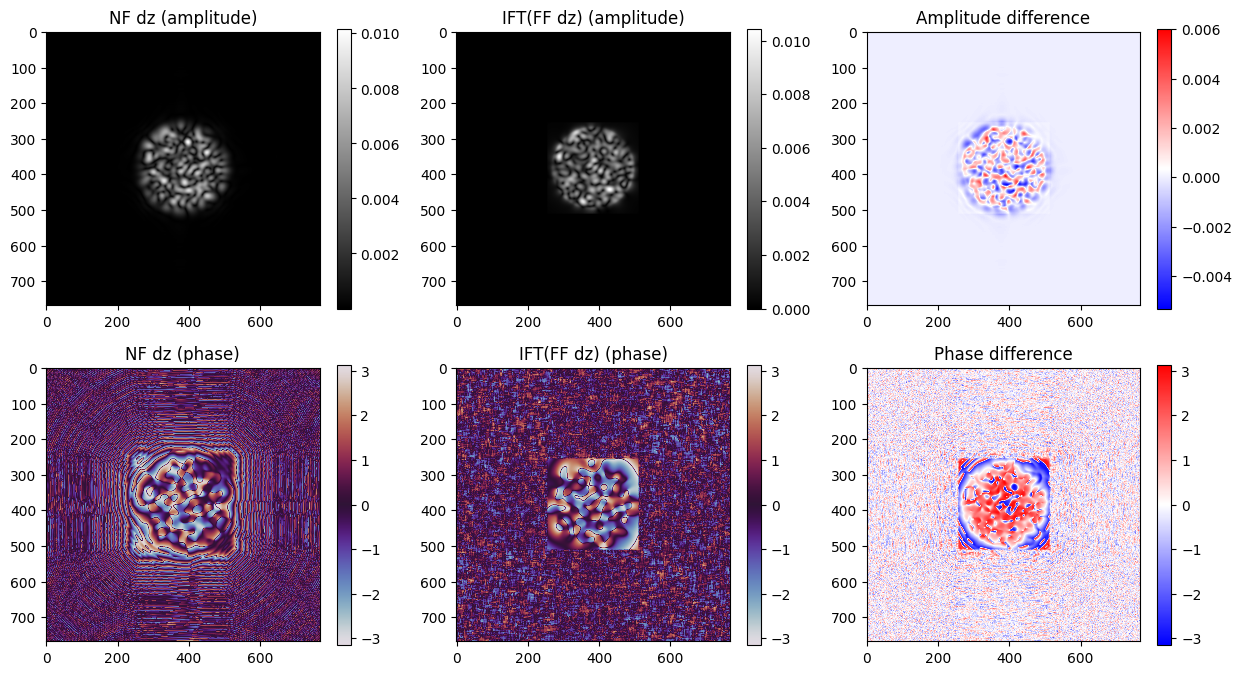

In [19]:
from waveoptics.propag.numpy import fft_2d, ifft_2d, frt_2d

s_nf = propagated_field.copy()
s_nf = np.pad(s_nf, pad_width=[256, 256])
s_ff = fft_2d(s_nf)

wl = 1064e-9
f = 5e-3
px_size = wl * f / (s_nf.shape[0] * grid.pixel_size)
idx_min = 300
idx_max = -300
win = slice(idx_min, idx_max, 1)

s_nf_dz = frt_2d(s_nf, pixel_size=grid.pixel_size, dz=25e-6, wavelength=wl)
s_ff_nf_dz = fft_2d(s_nf_dz)

s_ff_dz = frt_2d(s_ff, pixel_size=px_size, dz=35e-3, wavelength=wl)

s_ff_ift = ifft_2d(s_ff)
s_ff_dz_ift = ifft_2d(s_ff_dz)

_ = plot_fields(s_nf, s_nf_dz, intensity=False, figsize=(15,8), name=('NF', 'NF dz'))
_ = plot_fields(s_ff[win,win], s_ff_nf_dz[win,win], intensity=False, figsize=(15,8), name=('FF', 'FF(NF dz)'))
_ = plot_fields(s_ff[win,win], s_ff_dz[win,win], intensity=False, figsize=(15,8), name=('FF', 'FF dz'))
_ = plot_fields(s_nf, s_ff_dz_ift, intensity=False, figsize=(15,8), name=('NF', 'IFT(FF dz)'))
_ = plot_fields(s_nf_dz, s_ff_dz_ift, intensity=False, figsize=(15,8), name=('NF dz', 'IFT(FF dz)'))
